<a href="https://colab.research.google.com/github/GiX7000/computer-vision-on-CIFAR-10-from-basics-to-transformers/blob/main/5_pytorch_two_layer_nets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to PyTorch


In this notebook, we're going to leave behind the beautiful codebase and migrate to the most popular deep learning frameworks: [PyTorch](https://pytorch.org/)!

## Why do we use deep learning frameworks?

* Our code will now **run on GPUs**! This will allow our models to train much faster. When using a framework like PyTorch, Tensorflow or JAX you can harness the power of the GPU for your own custom neural network architectures without having to write CUDA code directly.
* We want to be ready to use one of these frameworks for our project so we can experiment **more efficiently** than if we were writing every feature we want to use by hand.
* We want to stand on the shoulders of giants! PyTorch is an amazing framework that will **make our life a lot easier**!
* Finally, we want to be exposed to the sort of deep learning code that runs into in **academia** and **industry**.

## What is PyTorch?

PyTorch is a system for executing **dynamic computational graphs** over Tensor objects that behave similarly as numpy ndarray.

It comes with a powerful **automatic differentiation engine** that removes the need for manual back-propagation.

## How do I learn PyTorch?

Find more details in the [API doc](http://pytorch.org/docs/stable/index.html).

For any questions that are not addressed by the API docs, the [PyTorch forum](https://discuss.pytorch.org/) is a much better place to ask than StackOverflow.

# Table of Contents

This project has four parts:

1. Part I, Preparation: we will use CIFAR-10 dataset.
2. Part II, **Barebones PyTorch**: *Abstraction level 1*, we will work directly with the lowest-level PyTorch Tensors.
3. Part III, **PyTorch Module API**: *Abstraction level 2*, we will use `nn.Module` to define arbitrary neural network architecture.
4. Part IV, **PyTorch Sequential API**: *Abstraction level 3*, we will use `nn.Sequential` to define a linear feed-forward network very conveniently.

Here is a table of comparison:

| API           | Flexibility | Convenience |
|---------------|-------------|-------------|
| Barebone      | High        | Low         |
| `nn.Module`     | High        | Medium      |
| `nn.Sequential` | Low         | High        |

# GPU

We manually switch to a GPU device on Colab by clicking `Runtime -> Change runtime type` and selecting `GPU` under `Hardware Accelerator`.

## Setup

Having switched to GPU, let's import packages.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as datasets
import torchvision.transforms as T

import numpy as np

USE_GPU = True
dtype = torch.float32 # We will be using float throughout this tutorial.

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss.
print_every = 100
print('using device:', device)

using device: cuda


# Part I. Preparation

## Load CIFAR-10 dataset

Now, let's load the CIFAR-10 dataset. PyTorch provides some convenient tools to automate this process even more for us.

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Define the mean and standard deviation for CIFAR-10.
mean = (0.4914, 0.4822, 0.4465)  # Precomputed mean for CIFAR-10.
std = (0.2023, 0.1994, 0.2010)   # Precomputed std for CIFAR-10.

# Define the transform for preprocessing and data augmentation.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Load the CIFAR-10 dataset.
dataset_path = '/content/drive/MyDrive/'  # Replace with your dataset path.
cifar10_dataset = datasets.CIFAR10(root=dataset_path, train=True, download=False, transform=transform) # Use download=True in case you do not have already downloaded.

# Split the dataset into train, val, and test sets.
num_train = 45000  # Number of training examples.
num_val = 5000    # Number of validation examples.
num_test = 10000   # Number of test examples (CIFAR-10 test set size).

train_dataset, val_dataset = random_split(cifar10_dataset, [num_train, num_val])

test_dataset = datasets.CIFAR10(root=dataset_path, train=False, download=True, transform=transform)

# Define DataLoaders.
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print dataset sizes for verification.
print(f"Train set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Files already downloaded and verified
Train set size: 45000
Validation set size: 5000
Test set size: 10000


## Visualize the class distributions

We have now defined our train, validation and test dataloaders. However, it would be good to check the data distribution of each dataloader, in order to check how many examples per class are included. We do this as a sanity check, as we want our dataloaders to be distributed close to uniform. Let's define some helper functions:

In [ ]:
import numpy as np
from collections import Counter

def get_class_distribution(loader, dataset_classes):
    """
    Computes the distribution of classes in a DataLoader.

    Args:
    - loader: DataLoader to inspect
    - dataset_classes: List of class names for the dataset

    Returns:
    - class_counts: Dictionary with class names as keys and counts as values
    """
    class_counts = Counter()
    for inputs, labels in loader:
        class_counts.update(labels.numpy())

    # Convert to a dictionary with class names.
    class_distribution = {dataset_classes[i]: class_counts[i] for i in range(len(dataset_classes))}
    return class_distribution

def display_class_distribution(distribution, title="Class Distribution"):
    """
    Displays the class distribution as a bar chart.

    Args:
    - distribution: Dictionary with class names as keys and counts as values
    - title: Title for the bar chart
    """
    import matplotlib.pyplot as plt

    class_names = list(distribution.keys())
    counts = list(distribution.values())

    plt.figure(figsize=(10, 6))
    plt.bar(class_names, counts)
    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.show()

Now, let's visualize the distribution of the examples per class for each dataloader:

Train DataLoader Distribution:
  airplane: 4494
  automobile: 4522
  bird: 4539
  cat: 4499
  deer: 4504
  dog: 4469
  frog: 4504
  horse: 4488
  ship: 4495
  truck: 4486


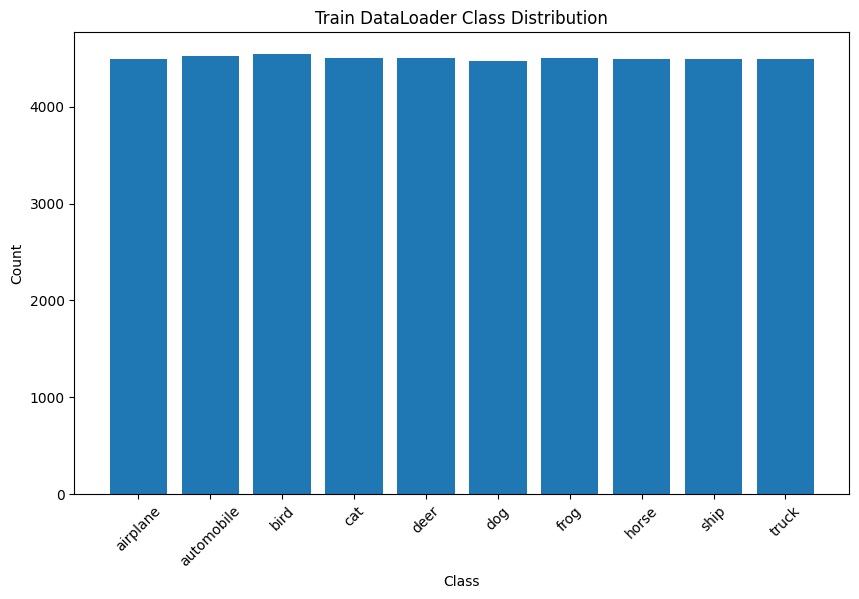

Validation DataLoader Distribution:
  airplane: 506
  automobile: 478
  bird: 461
  cat: 501
  deer: 496
  dog: 531
  frog: 496
  horse: 512
  ship: 505
  truck: 514


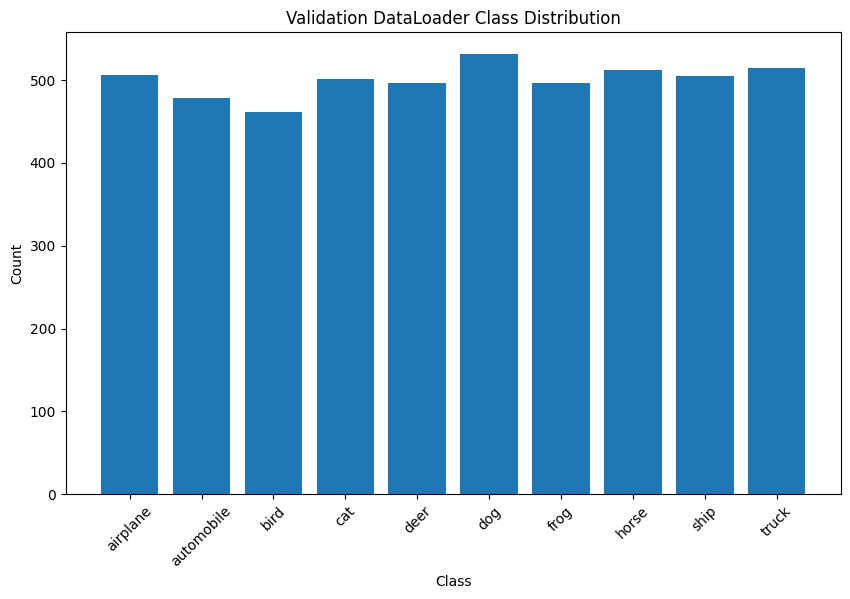

Test DataLoader Distribution:
  airplane: 1000
  automobile: 1000
  bird: 1000
  cat: 1000
  deer: 1000
  dog: 1000
  frog: 1000
  horse: 1000
  ship: 1000
  truck: 1000


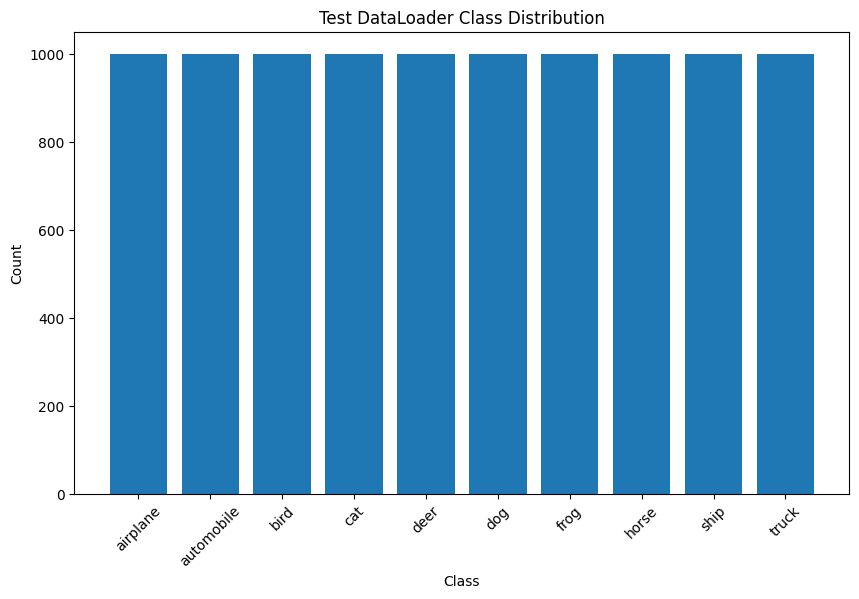

In [ ]:
# CIFAR-10 classes.
cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck']

# Compute and display class distribution for each DataLoader.
for loader, name in [(train_loader, "Train"), (val_loader, "Validation"), (test_loader, "Test")]:
    distribution = get_class_distribution(loader, cifar10_classes)
    print(f"{name} DataLoader Distribution:")
    for cls, count in distribution.items():
        print(f"  {cls}: {count}")
    display_class_distribution(distribution, title=f"{name} DataLoader Class Distribution")

## Visualize CIFAR-10 images

Now let's visualize a few examples from each class in the CIFAR-10 dataset.

By displaying images alongside their corresponding class labels, we can verify the dataset’s contents and ensure the classes are represented correctly.

This visualization helps us understand the data distribution and provides insights into the dataset’s characteristics.

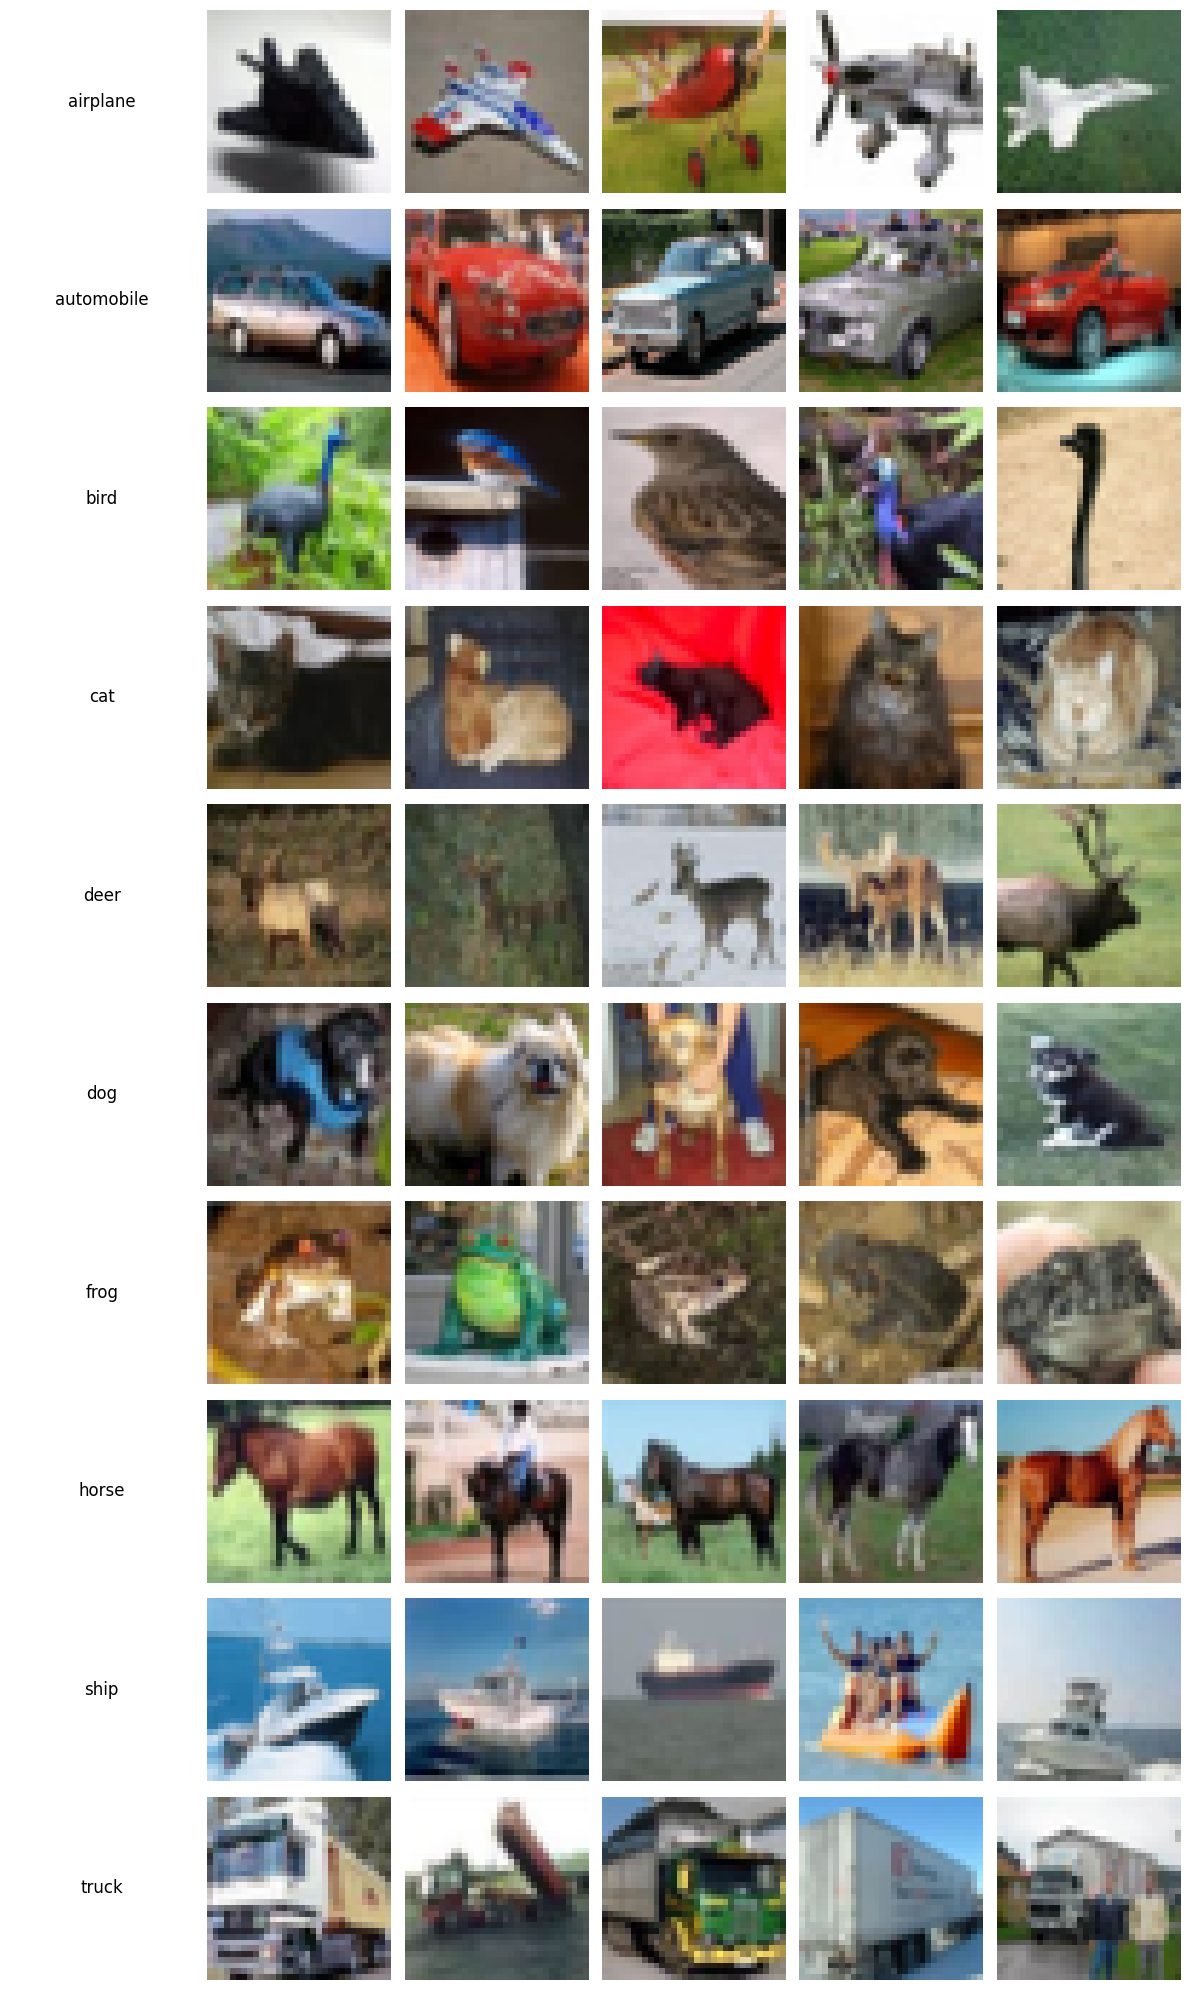

In [ ]:
import matplotlib.pyplot as plt

def visualize_images_per_class(dataset, dataset_classes, num_images=5):
    """
    Visualizes a few images from each class in the dataset.

    Args:
    - dataset: The dataset to sample from.
    - dataset_classes: List of class names for the dataset.
    - num_images: Number of images to display per class.
    """
    class_to_indices = {cls: [] for cls in range(len(dataset_classes))}

    # Group indices by class.
    for idx, (_, label) in enumerate(dataset):
        if len(class_to_indices[label]) < num_images:
            class_to_indices[label].append(idx)
        if all(len(indices) == num_images for indices in class_to_indices.values()):
            break

    # Plot the images.
    fig, axes = plt.subplots(len(dataset_classes), num_images + 1, figsize=((num_images + 1) * 2, len(dataset_classes) * 2))
    for cls_idx, cls_name in enumerate(dataset_classes):
        indices = class_to_indices[cls_idx]

        # Add class name to the first column of each row.
        axes[cls_idx, 0].text(0.5, 0.5, cls_name, fontsize=12, ha='center', va='center', transform=axes[cls_idx, 0].transAxes)
        axes[cls_idx, 0].axis("off")

        for img_idx, data_idx in enumerate(indices):
            img, label = dataset[data_idx]
            ax = axes[cls_idx, img_idx + 1]  # Shift by 1 for the class name column.
            img = img.permute(1, 2, 0)  # Convert CHW to HWC.
            img = img * torch.tensor(std).view(1, 1, 3) + torch.tensor(mean).view(1, 1, 3)  # De-normalize.
            img = torch.clamp(img, 0, 1)  # Clip values to valid range.
            ax.imshow(img)
            ax.axis("off")
    plt.tight_layout()
    plt.show()

# Visualize 5 images per class for CIFAR-10 train set.
visualize_images_per_class(cifar10_dataset, cifar10_classes, num_images=5)

# Part II. Two-Layer Network with Barebone PyTorch

PyTorch comes with high-level APIs to help us define model architectures conveniently, which we will cover in Part II of this tutorial. In this section, we will start with the **barebone** PyTorch elements to understand the autograd engine better. After this exercise, you will come to appreciate the high-level model API more.

We will start with a simple fully-connected ReLU network with two hidden layers and no biases for CIFAR-10 classification.

This implementation computes the **forward** pass using operations on PyTorch Tensors, and uses PyTorch `autograd` to compute gradients. It is important that you understand every line, because you will write a harder version after the example.

When we create a PyTorch Tensor with `requires_grad=True`, then operations involving that Tensor will not just compute values; they will also build up a **computational graph** in the background, allowing us to easily backpropagate through the graph to compute gradients of some Tensors with respect to a downstream loss. Concretely if x is a Tensor with `x.requires_grad == True` then after backpropagation `x.grad` will be another Tensor holding the gradient of x with respect to the scalar loss at the end.

## PyTorch Tensors: Flatten Function
A PyTorch Tensor is conceptionally similar to a numpy array: it is an n-dimensional grid of numbers and, like numpy, PyTorch provides many functions to efficiently operate on Tensors. As a simple example, we provide a `flatten` function below which reshapes image data for use in a fully-connected neural network.

Recall that image data is typically stored in a Tensor of shape `N x C x H x W`, where:

* `N` is the number of datapoints
* `C` is the number of channels
* `H` is the height of the intermediate feature map in pixels
* `W` is the height of the intermediate feature map in pixels

This is the right way to represent the data when we are doing something like a 2D convolution, that needs **spatial understanding** of where the intermediate features are relative to each other. When we use fully connected affine layers to process the image, however, we want each datapoint to be represented by a **single vector** - it's no longer useful to segregate the different channels, rows, and columns of the data. So, we use a "flatten" operation to collapse the `C x H x W` values per representation into a single long vector. The flatten function below first reads in the N, C, H, and W values from a given batch of data, and then returns a "view" of that data. "View" is analogous to numpy's "reshape" method: it reshapes x's dimensions to be N x ??, where ?? is allowed to be anything (in this case, it will be `C x H x W`, but we don't need to specify that explicitly).

In [ ]:
def flatten(x):
    N = x.shape[0] # read in N, C, H, W.
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image.

def test_flatten():
    x = torch.arange(12).view(2, 1, 3, 2)
    print('Before flattening: ', x)
    print('After flattening: ', flatten(x))

test_flatten()

Before flattening:  tensor([[[[ 0,  1],
          [ 2,  3],
          [ 4,  5]]],


        [[[ 6,  7],
          [ 8,  9],
          [10, 11]]]])
After flattening:  tensor([[ 0,  1,  2,  3,  4,  5],
        [ 6,  7,  8,  9, 10, 11]])


## Barebone PyTorch: Two-Layer Network

Here we define a function `two_layer_fc` which performs the **forward** pass of a two-layer fully-connected ReLU network on a batch of image data. After defining the forward pass we check that it doesn't crash and that it produces outputs of the right shape by running zeros through the network.


In [ ]:
import torch.nn.functional as F  # Useful stateless functions.

def two_layer_fc(x, params):
    """
    A fully-connected neural networks; the architecture is:
    NN is fully connected -> ReLU -> fully connected layer.
    Note that this function only defines the forward pass;
    PyTorch will take care of the backward pass for us.

    The input to the network will be a minibatch of data, of shape
    (N, d1, ..., dM) where d1 * ... * dM = D. The hidden layer will have H units,
    and the output layer will produce scores for C classes.

    Inputs:
    - x: A PyTorch Tensor of shape (N, d1, ..., dM) giving a minibatch of
      input data.
    - params: A list [w1, w2] of PyTorch Tensors giving weights for the network;
      w1 has shape (D, H) and w2 has shape (H, C).

    Returns:
    - scores: A PyTorch Tensor of shape (N, C) giving classification scores for
      the input data x.
    """
    # First, we flatten the image.
    x = flatten(x)  # shape: [batch_size, C x H x W].

    w1, w2 = params

    # Forward pass: compute predicted y using operations on Tensors. Since w1 and w2 have requires_grad=True, operations involving these Tensors will cause PyTorch to build a computational graph, allowing automatic computation of
    # gradients. Since we are no longer implementing the backward pass by hand we don't need to keep references to intermediate values. You can also use `.clamp(min=0)`, equivalent to F.relu().
    x = F.relu(x.mm(w1))
    x = x.mm(w2)
    return x


def two_layer_fc_test():
    hidden_layer_size = 42
    x = torch.zeros((64, 50), dtype=dtype)  # Minibatch size 64, feature dimension 50.
    w1 = torch.zeros((50, hidden_layer_size), dtype=dtype)
    w2 = torch.zeros((hidden_layer_size, 10), dtype=dtype)
    scores = two_layer_fc(x, [w1, w2])
    print(scores.size())  # Expected shape of [64, 10].

two_layer_fc_test()

torch.Size([64, 10])


## Barebone PyTorch: Initialization
Let's write a couple utility methods to initialize the weight matrices for our models.

- `random_weight(shape)` initializes a weight tensor with the Kaiming normalization method.
- `zero_weight(shape)` initializes a weight tensor with all zeros. Useful for instantiating bias parameters.

The `random_weight` function uses the Kaiming normal initialization method, described in:

He et al, *Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification*, ICCV 2015, https://arxiv.org/abs/1502.01852

In [ ]:
def random_weight(shape):
    """
    Create random Tensors for weights; setting requires_grad=True means that we
    want to compute gradients for these Tensors during the backward pass.
    We use Kaiming normalization: sqrt(2 / fan_in)
    """
    if len(shape) == 2:  # FC weight.
        fan_in = shape[0]
    else:
        fan_in = np.prod(shape[1:]) # conv weight [out_channel, in_channel, kH, kW].
    # randn is standard normal distribution generator.
    w = torch.randn(shape, device=device, dtype=dtype) * np.sqrt(2. / fan_in)
    w.requires_grad = True
    return w

def zero_weight(shape):
    return torch.zeros(shape, device=device, dtype=dtype, requires_grad=True)

# Create a weight of shape [3 x 5].
random_weight((3, 5))

tensor([[-0.2212,  1.0376, -0.3308, -2.0378,  0.9503],
        [ 0.2592, -0.1716,  1.3231, -0.3693, -0.3350],
        [-0.2682, -1.8820, -0.3477, -0.6216,  1.6126]], device='cuda:0',
       requires_grad=True)

## Barebone PyTorch: Check Accuracy
When training the model we will use the following function to check the accuracy of our model on the training or validation set.

When checking accuracy we don't need to compute any gradients; as a result we don't need PyTorch to build a computational graph for us when we compute scores. To prevent a graph from being built we scope our computation under a `torch.no_grad()` context manager.

In [ ]:
def check_accuracy_part2(loader, model_fn, params):
    """
    Check the accuracy of a classification model.

    Inputs:
    - loader: A DataLoader for the data split we want to check
    - model_fn: A function that performs the forward pass of the model,
      with the signature scores = model_fn(x, params)
    - params: List of PyTorch Tensors giving parameters of the model

    Returns: Nothing, but prints the accuracy of the model
    """
    # split = 'val' if loader.dataset.train else 'test'.
    split = 'val' if len(loader) == 79 else 'test'
    print('Checking accuracy on the %s set' % split)
    num_correct, num_samples = 0, 0
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # Move to GPU, if available.
            y = y.to(device=device, dtype=torch.int64)
            scores = model_fn(x, params)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f%%)' % (num_correct, num_samples, 100 * acc))

## BareBone PyTorch: Training Loop
We can now set up a basic training loop to train our network. We will train the model using stochastic gradient descent without momentum. We will use `torch.functional.cross_entropy` to compute the loss; you can [read about it here](http://pytorch.org/docs/stable/nn.html#cross-entropy).

The training loop takes as input the neural network function, a list of initialized parameters (`[w1, w2]` in our example), and learning rate.

In [ ]:
def train_part2(model_fn, params, learning_rate):
    """
    Train a model on CIFAR-10.

    Inputs:
    - model_fn: A Python function that performs the forward pass of the model.
      It should have the signature scores = model_fn(x, params) where x is a
      PyTorch Tensor of image data, params is a list of PyTorch Tensors giving
      model weights, and scores is a PyTorch Tensor of shape (N, C) giving
      scores for the elements in x.
    - params: List of PyTorch Tensors giving weights for the model
    - learning_rate: Python scalar giving the learning rate to use for SGD

    Returns: Nothing
    """
    for t, (x, y) in enumerate(train_loader):
        # Move the data to the proper device (GPU or CPU).
        x = x.to(device=device, dtype=dtype)
        y = y.to(device=device, dtype=torch.long)

        # Forward pass: compute scores and loss
        scores = model_fn(x, params)
        loss = F.cross_entropy(scores, y)

        # Backward pass: PyTorch figures out which Tensors in the computational graph has requires_grad=True and uses backpropagation to compute the gradient of the loss with respect to these Tensors, and stores the gradients in the .grad attribute of each Tensor.
        loss.backward()

        # Update parameters. We don't want to backpropagate through the parameter updates, so we scope the updates under a torch.no_grad() context manager to prevent a computational graph from being built.
        with torch.no_grad():
            for w in params:
                w -= learning_rate * w.grad

                # Manually zero the gradients after running the backward pass.
                w.grad.zero_()

        if t % print_every == 0:
            print('Iteration %d, loss = %.4f' % (t, loss.item()))
            check_accuracy_part2(val_loader, model_fn, params)
            print()

## BareBones PyTorch: Train a Two-Layer Network
Now we are ready to run the training loop for just one epoch. We need to explicitly allocate tensors for the fully connected weights, `w1` and `w2`.

Each minibatch of CIFAR-10 has 64 examples, so the tensor shape is `[64, 3, 32, 32]`.

After flattening, `x` shape will be `[64, 3 * 32 * 32]`. This will be the size of the first dimension of `w1`.
The second dimension of `w1` is the hidden layer size, which will also be the first dimension of `w2`.

Finally, the output of the network is a 10-dimensional vector that represents the probability distribution over 10 classes.

In [ ]:
hidden_layer_size = 500
learning_rate = 1e-3

w1 = random_weight((3 * 32 * 32, hidden_layer_size))
w2 = random_weight((hidden_layer_size, 10))

train_part2(two_layer_fc, [w1, w2], learning_rate)

Iteration 0, loss = 4.0320
Checking accuracy on the val set
Got 503 / 5000 correct (10.06%)

Iteration 100, loss = 2.3921
Checking accuracy on the val set
Got 1177 / 5000 correct (23.54%)

Iteration 200, loss = 2.0941
Checking accuracy on the val set
Got 1364 / 5000 correct (27.28%)

Iteration 300, loss = 2.1793
Checking accuracy on the val set
Got 1480 / 5000 correct (29.60%)

Iteration 400, loss = 2.0319
Checking accuracy on the val set
Got 1577 / 5000 correct (31.54%)

Iteration 500, loss = 1.9108
Checking accuracy on the val set
Got 1610 / 5000 correct (32.20%)

Iteration 600, loss = 2.1774
Checking accuracy on the val set
Got 1700 / 5000 correct (34.00%)

Iteration 700, loss = 1.8199
Checking accuracy on the val set
Got 1726 / 5000 correct (34.52%)



# Part III. Two-Layer Network with PyTorch Module API

Barebone PyTorch requires that we track all the parameter tensors by hand. This is fine for small networks with a few tensors, but it would be *extremely inconvenient* and *error-prone* to track tens or hundreds of tensors in larger networks.

PyTorch provides the `nn.Module` API for us to define arbitrary network architectures, while tracking every learnable parameters. In Part II, we implemented SGD ourselves. PyTorch also provides the `torch.optim` package that implements all the common optimizers, such as RMSProp, Adagrad, and Adam. Refer to the [doc](http://pytorch.org/docs/master/optim.html) for the exact specifications of each optimizer.

To use the Module API, we follow the steps below:

1. Subclass `nn.Module`, giving to our network class an intuitive name like `TwoLayerFC`.

2. In the constructor `__init__()`, we define all the layers we need as class attributes. Layer objects like `nn.Linear` are themselves `nn.Module` subclasses and contain learnable parameters, so that we don't have to instantiate the raw tensors ourselves. `nn.Module` will track these internal parameters for us. Refer to the [doc](http://pytorch.org/docs/master/nn.html) to learn more about the dozens of builtin layers.

3. In the `forward()` method, we define the *connectivity* of our network. We use the attributes defined in `__init__` as function calls that take tensor as input and output the "transformed" tensor. We do *not* create any new layers with learnable parameters in `forward()` (all of them are declared upfront in `__init__`)!

## Module API: Two-Layer Network

Now, we implement a two-layer fully connected neural network using PyTorch's `nn.Module` API. The network consists of two linear layers with a ReLU activation function in between, exactly as we did earlier using barebone PyTorch.

Network Architecture:
- The network will have one hidden layer.
- The input layer takes inputs of a specified size and feeds them into the hidden layer.
- The hidden layer should use ReLU as its activation function.
- The output layer produces scores for a specified number of classes.

Initialization:
- Initialize the weights of both linear layers using the Kaiming normalization method, which is suitable for layers followed by a ReLU activation function.

Forward Pass:
- Include a forward method that defines how data passes through the network.

In [ ]:
# Define a TwoLayerFC class using nn.Module.
class TwoLayerFC(nn.Module):

  """
  A two-layer fully-connected neural network with the architecture:
  fully connected linear layer -> ReLU -> fully connected linear layer.
  This function only defines the forward pass;
  PyTorch will take care of the backward pass for us!

  Inputs:
  -input size: a specified size of the input
  -hidden layer size: the number or hidden units
  -output: a specific size of output, the number of classes

  Returns: z = layer2(relu(layer1(flatten(x))))
  """

  def __init__(self, input_size, hidden_size, output_size):
    super().__init__()
    # What nn.modules we will use.
    self.layer_1 = nn.Linear(input_size, hidden_size)
    self.layer_2 = nn.Linear(hidden_size, output_size)
    self.relu = nn.ReLU()

    # Initialize weights.
    nn.init.kaiming_normal_(self.layer_1.weight)
    nn.init.kaiming_normal_(self.layer_2.weight)
    nn.init.zeros_(self.layer_1.bias)
    nn.init.zeros_(self.layer_2.bias)

  # Forward pass.
  def forward(self, x):
    """
    Inputs:
    - x: A PyTorch Tensor of shape (N, D)
    Returns:
    - logits: PyTorch Tensor of shape (N, C)
    """
    # Flatten x first to meet connectivity.
    x = flatten(x)
    z1 = self.layer_1(x)
    a1 = self.relu(z1)
    z2 = self.layer_2(a1)
    return z2

Now, test your implementation!

In [ ]:
def test_TwoLayerFC():
    input_size = 50
    x = torch.zeros((64, input_size), dtype=dtype)  # Minibatch size 64, feature dimension 50.
    model = TwoLayerFC(input_size, 42, 10)
    scores = model(x)
    print(scores.size())  # Expected shape of [64, 10].

test_TwoLayerFC()

torch.Size([64, 10])


## Module API: Check Accuracy

With the validation or test set, we can again check the classification accuracy of the neural network.

The below version is slightly different from the one in part II.

Here, we modify the existing function, `check_accuracy_part2`, which evaluates the accuracy of a classification model on a given dataset split (validation or test), to use PyTorch's object-oriented `Module API` instead. The original function takes a DataLoader, a model function, and a list of parameters as inputs to compute the model's accuracy. We create a new function, `check_accuracy_part3`, that achieves the same objective using a PyTorch model instance.

Differences to Implement:
- Parameter Handling: Instead of passing model parameters as a separate list, our function directly use a PyTorch model object, which encapsulates its parameters.

- Data Type for Labels: In the original function, labels `y` are converted to `torch.int64`. We change this to `torch.long` to ensure compatibility with PyTorch loss functions and model outputs.

- Forward Pass: we modify the way the forward pass is called. Instead of using a separate function `model_fn`, we will directly call the forward method on the `model` object with the input tensor `x`.

In [ ]:
# Define check_accuracy_part3() to be compatible with nn.Module API.
def check_accuracy_part3(loader, model):

    """
    Check the accuracy of a classification model.

    Inputs:
    - loader: A DataLoader for the data split we want to check
    - model_fn: A function that performs the forward pass of the model,
      with the signature scores = model_fn(x, params)

    Returns: Nothing, but prints the accuracy of the model
    """

    # split = 'val' if loader.dataset.train else 'test'.
    split = 'val' if len(loader) == 79 else 'test'
    print('Checking accuracy on the %s set' % split)
    num_correct, num_samples = 0, 0

    with torch.no_grad():
      for x, y in loader:
        x = x.to(device=device, dtype=dtype)  # Move to GPU, if available.
        y = y.to(device=device, dtype=torch.long)

        # Forward pass using the model's object.
        scores = model(x)
        _, preds = scores.max(1)

        # Calculate accuracy.
        num_correct += (preds == y).sum()
        num_samples += preds.size(0)
      acc = float(num_correct) / num_samples
      print('Got %d / %d correct (%.2f%%)' % (num_correct, num_samples, 100 * acc))

In the function above, if the condition len(loader) == 79 is True, we split variable is assigned to 'val', otherwise is assigned to 'test'. This is how it works and it is used to the print() command, a line below. The length of the validation dataloader is 79( ~5000 image samples / 64 images as batch size ) and because we need to check accuracy on these two different  dataloaders, this function helps us to do it for both, printing each time the loader we work on.

## Module API: Training Loop

We also use a slightly different training loop.

Rather than updating the values of the weights ourselves, we use an Optimizer object from the `torch.optim` package, which abstracts the notion of an optimization algorithm and provides implementations of most of the algorithms commonly used to optimize neural networks.

In [ ]:
def train_part3(model, optimizer, epochs=1):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.

    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for

    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # Ensure the model is on GPU, if any.
    for e in range(epochs):
        for t, (x, y) in enumerate(train_loader):
            model.train()  # Put model to training mode.
            x = x.to(device=device, dtype=dtype)  # Move X, y to device (GPU)
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients computed by the backwards pass.
            optimizer.step()

            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                check_accuracy_part3(val_loader, model)
                print()

## Module API: Train a Two-Layer Network

Now we are ready to run the training loop for one epoch. In contrast to part II, we don't explicitly allocate parameter tensors anymore.

We simply pass the input size, hidden layer size, and number of classes (i.e. output size) to the constructor of `TwoLayerFC`.

We also define an optimizer that tracks all the learnable parameters inside `TwoLayerFC`.

In [ ]:
hidden_layer_size = 500
learning_rate = 1e-3
model = TwoLayerFC(3 * 32 * 32, hidden_layer_size, 10)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

train_part3(model, optimizer)

Iteration 0, loss = 2.9923
Checking accuracy on the val set
Got 540 / 5000 correct (10.80%)

Iteration 100, loss = 2.1072
Checking accuracy on the val set
Got 1079 / 5000 correct (21.58%)

Iteration 200, loss = 2.0450
Checking accuracy on the val set
Got 1301 / 5000 correct (26.02%)

Iteration 300, loss = 2.3267
Checking accuracy on the val set
Got 1478 / 5000 correct (29.56%)

Iteration 400, loss = 1.8601
Checking accuracy on the val set
Got 1583 / 5000 correct (31.66%)

Iteration 500, loss = 1.8899
Checking accuracy on the val set
Got 1643 / 5000 correct (32.86%)

Iteration 600, loss = 2.0272
Checking accuracy on the val set
Got 1686 / 5000 correct (33.72%)

Iteration 700, loss = 1.6907
Checking accuracy on the val set
Got 1756 / 5000 correct (35.12%)



# Part IV. Two-Layer Network with PyTorch Sequential API

Part III introduced the PyTorch Module API, which allows us to define arbitrary learnable layers and their connectivity.

For simple models like a stack of feed forward layers, we still need to go through 3 steps: subclass `nn.Module`, assign layers to class attributes in `__init__`, and call each layer one by one in `forward()`. But, is there a more convenient way?

Fortunately, PyTorch provides a container Module called `nn.Sequential`, which merges the above steps into one. It is not as flexible as `nn.Module`, because we cannot specify more complex topology than a feed-forward stack, but it's good enough for many use cases.

## Sequential API: Two-Layer Network

Let's see how to rewrite our two-layer fully connected network example with `nn.Sequential`, and train it (for one epoch) using the training loop defined above.

In [ ]:
# We need to wrap `flatten` function in a module in order to stack it in nn.Sequential.
class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

hidden_layer_size = 500
learning_rate = 1e-3

model = nn.Sequential(
    Flatten(),
    nn.Linear(3 * 32 * 32, hidden_layer_size),
    nn.ReLU(),
    nn.Linear(hidden_layer_size, 10),
)

# Use of Nesterov momentum in optim.SGD.
optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                     momentum=0.9, nesterov=True)

train_part3(model, optimizer)

Iteration 0, loss = 2.3495
Checking accuracy on the val set
Got 605 / 5000 correct (12.10%)

Iteration 100, loss = 1.8936
Checking accuracy on the val set
Got 1770 / 5000 correct (35.40%)

Iteration 200, loss = 1.7262
Checking accuracy on the val set
Got 1923 / 5000 correct (38.46%)

Iteration 300, loss = 1.7483
Checking accuracy on the val set
Got 2013 / 5000 correct (40.26%)

Iteration 400, loss = 1.8041
Checking accuracy on the val set
Got 2102 / 5000 correct (42.04%)

Iteration 500, loss = 1.6985
Checking accuracy on the val set
Got 2165 / 5000 correct (43.30%)

Iteration 600, loss = 1.5394
Checking accuracy on the val set
Got 2155 / 5000 correct (43.10%)

Iteration 700, loss = 1.5438
Checking accuracy on the val set
Got 2206 / 5000 correct (44.12%)



The differences between this model and the previous ones are that in the two-layer sequential model, a) the forward pass is automatically and simply defined, by connecting all layers together in a sequence and b) the weight initialization is the default that Pytorch(Kaiming Uniform) uses and the most important c) in this case optimizer was Pytorch's SGD with momentum, while previously we had just Pytorch's SGD(second model) and custom SGD(train part 2 for the barebone model). So, this increase in performance is caused mainly by optimizer choice and little by weight initialization.  In the first case, weight initialization was completely random by us, while in the second we used Kaiming Uniform, the same Pytorch automatically uses in third model. The difference in accuracies between first and second model is tiny, so we can say that the big difference between third sequential model with the previous two is caused by SGD with momentum(as weight initilization in the second and third models is the same). This difference probably occurs because of the way the updating takes places in two cases. SGD updates taking into account the current gradients, while SGD with momentum takes into account more information than just the current gradients. To further improve the performance of the model, we should try several things like trying different optimizers along with different learning rates. We can also try different model's architectures by changing the hidden layer size, activation functions and maybe add some dropout regularization between the layers.

## Sequential API: Experiment with Optimizers

Given the baseline model implemented with PyTorch's Sequential API (as defined above), we are going to perform a learning rate search for each optimizer using as **optimizers**: `SGD with momentum`, `Adagrad`, `RMSProp`, `Adam`, `AdamW` and `NAdam` to find the learning rate that yields the best accuracy on the validation set, by training now this model for one epoch. We use `hidden_layer_size = 50`. Refer to the PyTorch documentation about [optimizers](https://pytorch.org/docs/stable/optim.html.).


In [ ]:
# Check_accuracy function with a % accuracy return here
def check_accuracy_part3_updated(loader, model):

    """
    Check the accuracy of a classification model.

    Inputs:
    - loader: A DataLoader for the data split we want to check
    - model: An instance of the model that performs the forward pass,
      with the signature scores = model_fn(x, params)

    Returns: Accuracy as a percentage and prints the accuracy of the model
    """

    # split = 'val' if loader.dataset.train else 'test'.
    split = 'val' if len(loader) == 79 else 'test'
    print('Checking accuracy on the %s set' % split)
    num_correct, num_samples = 0, 0

    with torch.no_grad():
      for x, y in loader:
        x = x.to(device=device, dtype=dtype)  # Move to GPU.
        y = y.to(device=device, dtype=torch.long)

        # Forward pass using the model's object.
        scores = model(x)
        _, preds = scores.max(1)

        # Calculate accuracy.
        num_correct += (preds == y).sum()
        num_samples += preds.size(0)
      acc = float(num_correct) / num_samples
      print('Got %d / %d correct (%.2f%%)' % (num_correct, num_samples, 100 * acc))

    return 100 * acc

In [ ]:
# Use train_part3 function to train the nn.Sequential 2-layer net for 1 epoch using different optimizers.
import pandas as pd

# Generate a simple list of 5 learning rates to try.
learning_rates = np.logspace(-2, -6, num=5) # (returns -> [1e-2, 1e-3, 1e-4, 1e-5, 1e-6]).
print("Learning rates to try:", learning_rates)

# Optimizers to try.
optimizers = {
    'SGD': optim.SGD,
    'SGD + momentum': lambda params, lr: optim.SGD(params, lr=lr, momentum=0.9, nesterov=True),
    'Adagrad': optim.Adagrad,
    'RMSProp': optim.RMSprop,
    'Adam': optim.Adam,
    'AdamW': optim.AdamW,
    'NAdam': optim.NAdam
}
print("Optimizers to try:", list(optimizers.keys()))

# Store learning rate for best val accuracy for each optimizer.
optim_results_list = []

# Loop over optmizers.
for optimizer_name, optimizer_fn in optimizers.items():
  print(f"\nTesting {optimizer_name} optimizer...")

  # Track best lr and acc for the current optimizer.
  best_lr = None
  best_optim_val_accuracy = 0

  # Loop over learning rates.
  for lr in learning_rates:
    print(f"\nLearning rate: {lr}... \n")

    # Re-initializa model for each optimizer and learning rate(with 50 hidden_layer_size).
    model = nn.Sequential(
    Flatten(),
    nn.Linear(3 * 32 * 32, 50),
    nn.ReLU(),
    nn.Linear(50, 10),
    ).to(device)

    # Set the optimizer.
    optimizer = optimizer_fn(model.parameters(), lr=lr)

    # Train the model using the above defined part3 train function.
    train_part3(model, optimizer)

    # Check accuracy on validation set using the above updated function for accuracy.
    val_accuracy = check_accuracy_part3_updated(val_loader, model)

    # Keep track of best val_accuracy.
    if val_accuracy > best_optim_val_accuracy:
      best_optim_val_accuracy = val_accuracy
      best_lr = lr

  # Save the results in a list.
  optim_results_list.append((optimizer_name, best_lr, best_optim_val_accuracy))

  # Print best results for the current optimizer.
  print(f"\nBest learning rate for {optimizer_name}: {best_lr}")
  print(f"Best validation accuracy for {optimizer_name}: {best_optim_val_accuracy:.2f}%\n")

# Print the results in a table in desc order.
optimizers_df = pd.DataFrame(optim_results_list, columns=['Optimizer', 'Best Learning Rate', 'Validation Accuracy (%)'])
optimizers_df = optimizers_df.sort_values(by='Validation Accuracy (%)', ascending=False)
print("\n", optimizers_df.to_string(index=False))

# Print optimizer with higher validattion accuracy.
best_optim_result = max(optim_results_list, key=lambda x: x[2])
print(f"\nBest result: {best_optim_result}")

Learning rates to try: [1.e-02 1.e-03 1.e-04 1.e-05 1.e-06]
Optimizers to try: ['SGD', 'SGD + momentum', 'Adagrad', 'RMSProp', 'Adam', 'AdamW', 'NAdam']

Testing SGD optimizer...

Learning rate: 0.01... 

Iteration 0, loss = 2.3268
Checking accuracy on the val set
Got 609 / 5000 correct (12.18%)

Iteration 100, loss = 1.7575
Checking accuracy on the val set
Got 1678 / 5000 correct (33.56%)

Iteration 200, loss = 1.7010
Checking accuracy on the val set
Got 1902 / 5000 correct (38.04%)

Iteration 300, loss = 1.8249
Checking accuracy on the val set
Got 1967 / 5000 correct (39.34%)

Iteration 400, loss = 1.6875
Checking accuracy on the val set
Got 2001 / 5000 correct (40.02%)

Iteration 500, loss = 1.5778
Checking accuracy on the val set
Got 2040 / 5000 correct (40.80%)

Iteration 600, loss = 1.4716
Checking accuracy on the val set
Got 2098 / 5000 correct (41.96%)

Iteration 700, loss = 1.6309
Checking accuracy on the val set
Got 2109 / 5000 correct (42.18%)

Checking accuracy on the val s

Best classification results (based on validation accuracy) per optimizer in the following Table:

| Optimizer | best LR | Validation Accuracy (%) |
|----------|----------|----------|
| SGD    | 1e-2   | 41.38   |
| SGD + momentum    | 1e-3   | 42.64   |
| Adagrad    | 1e-2   | 41.42   |
| RMSProp    | 1e-4   | 42.14   |
| Adam    | 1e-3   | 41.86   |
| AdamW    | 1e-3   | 42.54   |
| NAdam    | 1e-4   | 42.50   |



## Sequential API: Experiment with Activation Functions

Using the optimizer and learning rate that performed the best in the previous experiment, we train the same model for 1 epoch using different **activation functions**: `Leaky ReLU`, `ELU`, `GeLU`, `PReLU`, `SiLU` and `Mish` (`hidden_layer_size = 50`). Refer to the PyTorch documentation about [non-linear activations](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity) to implement these activation functions.

In [ ]:
# Use train_part3 function to train the nn.Sequential 2-layer net for 1 epoch using different activations.

# Activation functions to try.
activation_functions = [
    ('ReLU', nn.ReLU()),
    ('LeakyReLU', nn.LeakyReLU(negative_slope=0.01)),
    ('ELU', nn.ELU()),
    ('GeLU', nn.GELU()),
    ('PReLU', nn.PReLU()),
    ('SiLU', nn.SiLU()),
    ('Mish', nn.Mish())  ]
print("Activation functions to try:", [name for name, _ in activation_functions])

# Store the results in a list.
activation_results_list = []

# Loop over activation functions list.
for activation_name, activation_fn in activation_functions:
  print(f"\nTesting {activation_name} activation function...")

  # Keep track of best validation accuracy.
  best_activ_val_accuracy = 0

  # Re-initialize the model for the current activation function.
  model = nn.Sequential(
      Flatten(),
      nn.Linear(3 * 32 * 32, 50),
      activation_fn,
      nn.Linear(50, 10)
      ).to(device)

  # Set as optimizer the best one from above.
  best_optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, nesterov=True)

  # Train the model.
  train_part3(model, best_optimizer)

  # Check accuracy on validation set.
  val_accuracy = check_accuracy_part3_updated(val_loader, model)

  # Track best validation accuracy.
  if val_accuracy > best_activ_val_accuracy:
    best_activ_val_accuracy = val_accuracy

  # Save the results in a list.
  activation_results_list.append((activation_name, best_activ_val_accuracy))

  # Print best val accuracy for the current activation function.
  print(f"\nBest validation accuracy for {activation_name}: {best_activ_val_accuracy:.2f}%\n")

# Put all the results in a table and print it.
activation_functions_df = pd.DataFrame(activation_results_list, columns=['Activation Function', 'Validation Accuracy (%)'])
activation_functions_df = activation_functions_df.sort_values(by='Validation Accuracy (%)', ascending=False)
print("\n", activation_functions_df.to_string(index=False))

# Print best result.
best_activ_result = max(activation_results_list, key=lambda x: x[1])
print(f"\nBest result: {best_activ_result}")

Activation functions to try: ['ReLU', 'LeakyReLU', 'ELU', 'GeLU', 'PReLU', 'SiLU', 'Mish']

Testing ReLU activation function...
Iteration 0, loss = 2.3138
Checking accuracy on the val set
Got 616 / 5000 correct (12.32%)

Iteration 100, loss = 1.9467
Checking accuracy on the val set
Got 1673 / 5000 correct (33.46%)

Iteration 200, loss = 1.6186
Checking accuracy on the val set
Got 1878 / 5000 correct (37.56%)

Iteration 300, loss = 1.7952
Checking accuracy on the val set
Got 1980 / 5000 correct (39.60%)

Iteration 400, loss = 1.5500
Checking accuracy on the val set
Got 1988 / 5000 correct (39.76%)

Iteration 500, loss = 1.6725
Checking accuracy on the val set
Got 2060 / 5000 correct (41.20%)

Iteration 600, loss = 1.7700
Checking accuracy on the val set
Got 2117 / 5000 correct (42.34%)

Iteration 700, loss = 1.5513
Checking accuracy on the val set
Got 2100 / 5000 correct (42.00%)

Checking accuracy on the val set
Got 2125 / 5000 correct (42.50%)

Best validation accuracy for ReLU: 42.50

Classification results in the following Table:

| Activation function | Validation Accuracy |
|----------|----------|
| ReLU    | 42.50   |
| Leaky ReLU    | 42.84   |
| ELU    | 42.24   |
| GeLU    | 42.96   |
| PReLU    | 41.98   |
| SiLU    | 43.10   |
| Mish    | 42.66   |



## Sequential API: Experiment with hidden layer sizes

Using the optimizer, learning rate, and activation function that gave the best results earlier, we experiment with different hidden layer sizes. We try the following values: `5`, `10`, `20`, `50`, `100`, `200`, `500` for one epoch.

Hidden layer sizes to try: [5, 10, 20, 50, 100, 200, 500]

Testing hidden layer size: 5
Iteration 0, loss = 2.2885
Checking accuracy on the val set
Got 575 / 5000 correct (11.50%)

Iteration 100, loss = 2.1192
Checking accuracy on the val set
Got 1299 / 5000 correct (25.98%)

Iteration 200, loss = 1.9902
Checking accuracy on the val set
Got 1376 / 5000 correct (27.52%)

Iteration 300, loss = 1.9956
Checking accuracy on the val set
Got 1448 / 5000 correct (28.96%)

Iteration 400, loss = 1.9554
Checking accuracy on the val set
Got 1511 / 5000 correct (30.22%)

Iteration 500, loss = 1.8516
Checking accuracy on the val set
Got 1544 / 5000 correct (30.88%)

Iteration 600, loss = 1.8762
Checking accuracy on the val set
Got 1552 / 5000 correct (31.04%)

Iteration 700, loss = 1.8011
Checking accuracy on the val set
Got 1526 / 5000 correct (30.52%)

Checking accuracy on the test set
Got 14063 / 45000 correct (31.25%)
Checking accuracy on the val set
Got 1505 / 5000 correct (30.10%)
Train Accura

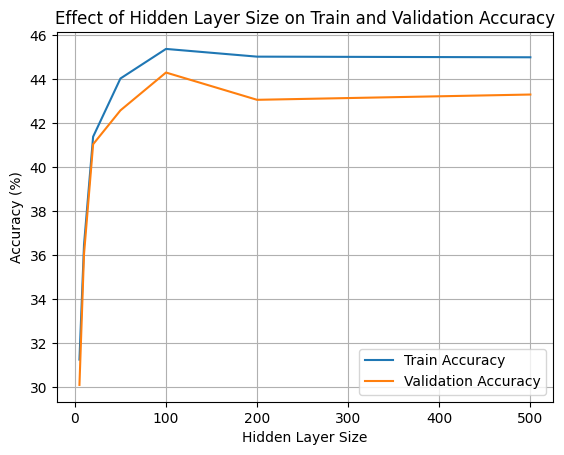

In [ ]:
# Use train_part3 function to train the nn.Sequential 2-layer net for 1 epoch using best optimizer, learning rate, and activation, adjusting the hidden layer sizes.                                                    #

# Store train, val accuracies for plotting.
train_accuracies = []
val_accuracies = []

layer_sizes_results = []

# Hidden layer sizes to experiment with.
hidden_layer_sizes = [5, 10, 20, 50, 100, 200, 500]
print("Hidden layer sizes to try:", hidden_layer_sizes)

# Loop over the hidden_layer_sizes.
for hidden_layer_size in hidden_layer_sizes:
  print(f"\nTesting hidden layer size: {hidden_layer_size}")

  # Update the sequential model with the current hidden layer size.
  model = nn.Sequential(
      Flatten(),
      nn.Linear(3 * 32 * 32, hidden_layer_size),
      nn.SiLU(),  # Best performing activation function according to the previous experiment.
      nn.Linear(hidden_layer_size, 10)
      ).to(device)

  # Ensure best optimizer is set for the current experiment.
  best_optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, nesterov=True)

  # Train the model using the best above optimizer.
  train_part3(model, best_optimizer)

  # Store all results to lists.
  train_accuracies.append(check_accuracy_part3_updated(train_loader, model))
  val_accuracies.append(check_accuracy_part3_updated(val_loader, model))
  layer_sizes_results.append((hidden_layer_size, train_accuracies[-1], val_accuracies[-1]))

  # Print train and val accuracies for the current hidden layer size.
  print(f"Train Accuracy: {train_accuracies[-1]:.2f}%, Validation Accuracy: {val_accuracies[-1]:.2f}%")

# Print all the results in a table.
hidden_layer_sizes_df = pd.DataFrame(layer_sizes_results, columns=['Hidden Layer Size', 'Train Accuracy (%)', 'Validation Accuracy (%)'])
print("\n", hidden_layer_sizes_df.to_string(index=False))

# Print the best result.
best_layer_size_result = max(layer_sizes_results, key=lambda x: x[2])
print(f"\nBest result: {best_layer_size_result}")

# Plot train and validation accuracies vs. hidden layer sizes.
plt.figure
plt.plot(hidden_layer_sizes, train_accuracies, label='Train Accuracy')
plt.plot(hidden_layer_sizes, val_accuracies, label='Validation Accuracy')
plt.xlabel('Hidden Layer Size')
plt.ylabel('Accuracy (%)')
plt.title('Effect of Hidden Layer Size on Train and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()



*   Overfitting Analysis:

 As we see, after 20 neurons as hidden layer size, the gap between training and validation lines starts to become bigger and as it continues to increase both training and validation accuracies increase at some point(100) and then stabilize, with training accuracy always be higher than validation accuracy. This means that the model performs very well on the training data but fails to generalize on new unseen validation data(overfitting). So, increasing hidden layer size, we have more parameters(capacity) to fit on training data and make our model more complex and precise on learning patterns. At the same time, the capability of the model to generalize on validation data decreases. So, as long as the hidden layer size increases, the training and validation accuracies are getting higher and, their gap grows or remains the same.



*   Best Hidden Layer Size:

  When the value of the of hidden_layer_sizes is equal to 100, the best validation accuracy achieved in our case, even our model suffers from overfitting. Generally, for smaller hidden layer sizes, a model might not have enough capacity to learn complex, but necessary, relationships in the data and lower validation accuracy can occur. For larger hidden layer sizes, the effect of overfitting is becoming more and more intense, meaning the model captures too much complexity(having too much capacity) and the validation accuracy stops to increase or increase very slow in comparison with training accuracy, which follows the same pattern. Here, we observe that when hidden_layer_size>100, both train and validation accuracies stop increasing with the same rate as before(almost flat), meaning our model doesn't learns anything more on training data and, thus, we don't see any improvement on validation data. So, the optimal value for hidden layer size can be somewhere in the middle where the closest distance between training and validation accuracies is occured. At that point we have 100 hidden neurons in the net with also a very descent and high validation accuracy(actually closest distance is at 20 hidden neurons, but we don't get such good validation accuuracy there).   



*   Generalization Trade-off:

 Having almost alreaday said it above, generally, for small hidden layer size, we have a small model's capacity and maybe underfitting, as it cannot capture the patterns in training data. For larger hidden layer sizes, we have a model that captures almost every detail of the training dataset and, in this way, it cannot generelizes on new unseen data and overfits. Therefore, there is a trade-off between model's capacity and generalization. So, we need to play a lot to find the best choice of hidden layer size in order to achieve a high validation accuracy with limited overfitting risk and, therefore, get bettter predictions.

## Sequential API: Experiment with Dropout

Overfitting can occur, especially as our model becomes more complex. We will now experiment with [Dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html) to regularize our model. The experiment includes:

1.	Adding a Dropout layer after the first fully connected layer in your model.

2.	Training the model with the best configuration for one epoch with dropout probabilities of `0.1`, `0.3`, `0.5`, `0.7`, `0.9`.

3.	Recording the validation accuracy for each dropout probability.

4. Plotting a graph showing dropout probability (x-axis) vs. train and validation accuracy (y-axis).


Testing dropout probability: 0.1
Iteration 0, loss = 2.3474
Checking accuracy on the val set
Got 564 / 5000 correct (11.28%)

Iteration 100, loss = 1.7621
Checking accuracy on the val set
Got 1691 / 5000 correct (33.82%)

Iteration 200, loss = 1.9170
Checking accuracy on the val set
Got 1849 / 5000 correct (36.98%)

Iteration 300, loss = 1.6144
Checking accuracy on the val set
Got 1982 / 5000 correct (39.64%)

Iteration 400, loss = 1.8906
Checking accuracy on the val set
Got 2009 / 5000 correct (40.18%)

Iteration 500, loss = 1.9214
Checking accuracy on the val set
Got 2077 / 5000 correct (41.54%)

Iteration 600, loss = 1.8656
Checking accuracy on the val set
Got 2097 / 5000 correct (41.94%)

Iteration 700, loss = 1.6533
Checking accuracy on the val set
Got 2152 / 5000 correct (43.04%)

Checking accuracy on the test set
Got 19556 / 45000 correct (43.46%)
Checking accuracy on the val set
Got 2105 / 5000 correct (42.10%)
Train Accuracy: 43.46%, Validation Accuracy: 42.10%

Testing dropo

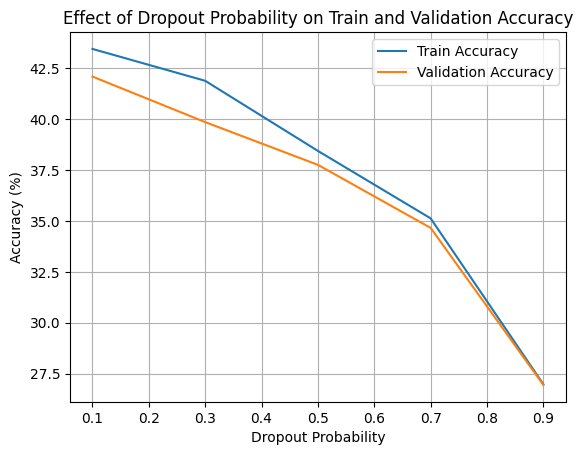

In [ ]:
# Modify the nn.Sequential 2-layer net to include a Dropout layer after the first fully connected layer. Train the model for 1 epoch using the best optimizer, learning rate, and activation, with dropout rates of 0.1, 0.3, 0.5, 0.7, and 0.9. Record validation accuracy for each rate.

# Storage lists.
dropout_train_accuracies = []
dropout_val_accuracies = []
dropout_results = []

# dDropout probabilities to experiment with.
dropout_probs = [0.1, 0.3, 0.5, 0.7, 0.9]

# Loop over the dropout probabilities.
for dropout_prob in dropout_probs:
  print(f"\nTesting dropout probability: {dropout_prob}")

  # Create a new sequential model for the current dropout probability.
  model = nn.Sequential(
      Flatten(),
      nn.Linear(3 * 32 * 32, 100), # Best hidden layer size.
      nn.SiLU(), # Best activation function.
      nn.Dropout(p=dropout_prob),
      nn.Linear(100, 10) # Best hidden layer size.
  ).to(device)

  # Ensure best optimizer is set for the current experiment.
  best_optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, nesterov=True)

  # Train the current model.
  train_part3(model, best_optimizer)

  # Record train and validation accuracies.
  dropout_train_accuracies.append(check_accuracy_part3_updated(train_loader, model))
  dropout_val_accuracies.append(check_accuracy_part3_updated(val_loader, model))

  dropout_results.append((dropout_prob, dropout_val_accuracies[-1] - dropout_train_accuracies[-1]))

  # Print accuracies for the current dropout probability.
  print(f"Train Accuracy: {dropout_train_accuracies[-1]:.2f}%, Validation Accuracy: {dropout_val_accuracies[-1]:.2f}%")

# Print all the results in a table.
dropout_results_df = pd.DataFrame(dropout_results, columns=['Dropout Probability', 'Validation Accuracy - Training Accuracy (%)'])
print("\n", dropout_results_df.to_string(index=False))

# Print best result according to validation accuracy.
best_dropout_result = max(dropout_results, key=lambda x: x[1])
print(f"\nBest difference result: {best_dropout_result}")

# Plot train and validation accuracies vs. dropout probabilities.
plt.figure
plt.plot(dropout_probs, dropout_train_accuracies, label='Train Accuracy')
plt.plot(dropout_probs, dropout_val_accuracies, label='Validation Accuracy')
plt.xlabel('Dropout Probability')
plt.ylabel('Accuracy (%)')
plt.title('Effect of Dropout Probability on Train and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

*   Overfitting Reduction:

  For a low dropout probability, only a small amount of neurons dropped out, so the model still has the capacity to memorize well the training data and overfits. As the dropout probability increases to 0.3 and 0.5, validation accuracy is coming closer the training accuracy, meaning that the model works better, addressing overfitting. Moreover, as we keep increasing dropout probability to higher vales (0.7 and 0.9), overfitting is almost dead, especially when dropout probability is 0.9(validation and training accuraccies are almost the equal). However, as we gradually defeat overfitting by increasing dropout probability, validation accuracy decreases, so, obviously, we have to end with a good validation accuracy with low overfitting. To conclude, by using dropout regularization layer, the gap between training and validation sets not only decreases, but overfitting stops to exist at some point.

*   Best Dropout Probability:

  For p=0.1, we take the highest validation accuracy. When p is low, it means that few neurons are deactivated, so the model behaves like to its previous state and performs almost the same, meaning it carries all overfitting that it has before adding dropout with a slight decrease. Despite the model achieved best validation accuracy here, its prediction ability suffers and cannot generalize as we want(big gap between train and validation accuracies).



*   Dropout Impact:

  As we see, higher dropout probabilities drive to very low train and validation accuracies, ending with validation accuracy very close to training one, meaning that overfitting has completely been defeated. Although, this makes the model struggle to learn effectively because too many neurons are randomly disabled during training, limiting its ability to learn patterns on training data. This, on the other hand, can lead to underfitting, so extreme dropout probabilities, either too low or too high may not be finally useful to us to take a good validation accuracy with low overfitting.  



*   Generalization:

  As we observe above, when the training and validation lines converge, dropout regularization effectively defeats overfitting. By disabling neurons, we enforce the model capturing more generalizable features on the training data rather than memorizing every detail of it. Higher dropout probabilities means most neurons are out. When suffering from overfitting, this helps the model to generalize better on unseen data and make better predictions. However, as dropout probability increases too much, both accuracies decline(another trade-off here we should always have in our mind, when tuning dropout rates), so what we ideally want is to have high validation accuracy without overfitting.


## Sequential API: Experiment with Learning Rate Schedulers

Learning rate schedulers adjust the learning rate during training and can help the model converge more effectively. Using the best configuration so far (optimizer, learning rate, activation function, and hidden layer size), we experiment with learning rate schedulers (by training for 5 epochs each scheduler):

- `StepLR`
- `LinearLR`
- `CosineAnnealingLR`
- `ExponentialLR`
- `ReduceLROnPlateau`

Refer to the PyTorch [scheduler documentation](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate) to implement these schedulers.


Testing StepLR scheduler...
Epoch 1/5
Iteration 0, loss = 2.2674
Checking accuracy on the val set
Got 558 / 5000 correct (11.16%)

Iteration 100, loss = 1.9417
Checking accuracy on the val set
Got 1707 / 5000 correct (34.14%)

Iteration 200, loss = 1.8531
Checking accuracy on the val set
Got 1891 / 5000 correct (37.82%)

Iteration 300, loss = 1.8468
Checking accuracy on the val set
Got 1973 / 5000 correct (39.46%)

Iteration 400, loss = 1.5034
Checking accuracy on the val set
Got 2047 / 5000 correct (40.94%)

Iteration 500, loss = 1.8833
Checking accuracy on the val set
Got 2121 / 5000 correct (42.42%)

Iteration 600, loss = 1.4554
Checking accuracy on the val set
Got 2124 / 5000 correct (42.48%)

Iteration 700, loss = 1.6131
Checking accuracy on the val set
Got 2166 / 5000 correct (43.32%)

Checking accuracy on the val set
Got 2179 / 5000 correct (43.58%)
Epoch 2/5
Iteration 0, loss = 1.4062
Checking accuracy on the val set
Got 2173 / 5000 correct (43.46%)

Iteration 100, loss = 1.72

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Got 536 / 5000 correct (10.72%)

Iteration 100, loss = 2.0084
Checking accuracy on the val set
Got 1701 / 5000 correct (34.02%)

Iteration 200, loss = 1.8381
Checking accuracy on the val set
Got 1866 / 5000 correct (37.32%)

Iteration 300, loss = 1.6833
Checking accuracy on the val set
Got 1979 / 5000 correct (39.58%)

Iteration 400, loss = 1.9256
Checking accuracy on the val set
Got 2017 / 5000 correct (40.34%)

Iteration 500, loss = 1.8701
Checking accuracy on the val set
Got 2112 / 5000 correct (42.24%)

Iteration 600, loss = 1.5909
Checking accuracy on the val set
Got 2130 / 5000 correct (42.60%)

Iteration 700, loss = 1.4353
Checking accuracy on the val set
Got 2121 / 5000 correct (42.42%)

Checking accuracy on the val set
Got 2112 / 5000 correct (42.24%)
Epoch 2/5
Iteration 0, loss = 1.4510
Checking accuracy on the val set
Got 2120 / 5000 correct (42.40%)

Iteration 100, loss = 1.4971
Checking accuracy on the val set
Got 2176 / 5000 correct (43.52%)

Iteration 200, loss = 1.3865


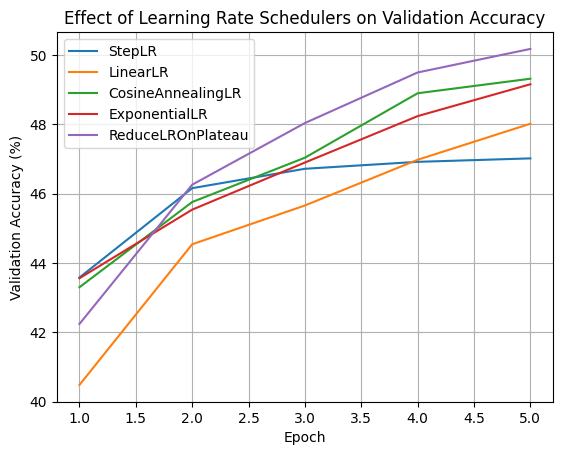

In [ ]:
# Learning rate schedulers to try.
from torch.optim.lr_scheduler import StepLR, LinearLR, CosineAnnealingLR, ExponentialLR, ReduceLROnPlateau
schedulers = [StepLR, LinearLR, CosineAnnealingLR, ExponentialLR, ReduceLROnPlateau]

# Storage dictionaries initializations.
schedulers_val_history = {}
schedulers_accuracies = {}

# Set the number of epochs.
epochs = 5

# Loop over lr schedulers.
for sch in schedulers:
  print(f"\nTesting {sch.__name__} scheduler...")

  # Take the model with best configuration so far.
  model = nn.Sequential(
      Flatten(),
      nn.Linear(3 * 32 * 32, 100), # Best hidden layer size.
      nn.SiLU(), # Best activation function.
      nn.Linear(100, 10), # Best hidden layer size.
      nn.Dropout(p=0.0) # No dropout probability.
      ).to(device)

  # Adjust best optimizer.
  best_optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, nesterov=True)

  # Every scheduler has its own required arguments.
  if sch == StepLR:
    # StepLR requires 'step_size' and 'gamma'.
    scheduler = sch(best_optimizer, step_size=2, gamma=0.1)
  elif sch == LinearLR:
    # LinearLR requires 'start_factor' and 'total_iters'.
    scheduler = sch(best_optimizer, start_factor=0.5, total_iters=5)
  elif sch == CosineAnnealingLR:
    # CosineAnnealingLR requires 'T_max' and 'eta_min'.
    scheduler = sch(best_optimizer, T_max=10, eta_min=0)
  elif sch == ExponentialLR:
    # ExponentialLR requires 'gamma'.
    scheduler = sch(best_optimizer, gamma=0.9)
  elif sch == ReduceLROnPlateau:
    # ReduceLROnPlateau requires 'mode', 'factor', and 'patience'.
    scheduler = sch(best_optimizer, mode='max', factor=0.1, patience=2, verbose=True)

  schedulers_val_accuracies = [] # Storage list to save val accuracies per epoch for the current scheduler.

  # Iterate over epochs.
  for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")

    # Train the model.
    train_part3(model, best_optimizer)

    # Store validation accuracy for the current epoch for the current lr scheduler.
    val_accuracy = check_accuracy_part3_updated(val_loader, model)
    schedulers_val_accuracies.append(val_accuracy)

    # Adjust the learning rate.
    if sch == ReduceLROnPlateau:
      scheduler.step(val_accuracy) # requires val accuracy
    else:
      scheduler.step()

  # Print val accuracy for the current scheduler.
  print(f"\nValidation Accuracy for {sch.__name__}: {schedulers_val_accuracies[-1]:.2f}%\n")

  # Store the val accuracies for the current scheduler.
  schedulers_val_history[sch.__name__] = schedulers_val_accuracies

# Print the results in desc order in a table.
for scheduler_name, val_accuracies in schedulers_val_history.items():
  schedulers_accuracies[scheduler_name] = val_accuracies[-1]
schedulers_df = pd.DataFrame(schedulers_accuracies.items(), columns=['Scheduler', 'Validation Accuracy (%)'])
schedulers_df = schedulers_df.sort_values(by='Validation Accuracy (%)', ascending=False)
print("\n", schedulers_df.to_string(index=False))

# Print best LR Scheduler.
best_scheduler_result = max(schedulers_accuracies.items(), key=lambda x: x[1])
print(f"\nBest result: {best_scheduler_result}")
print("")

# Plot the results.
plt.figure
for scheduler_name, val_accuracies in schedulers_val_history.items():
  plt.plot(range(1, epochs+1), val_accuracies, label=scheduler_name)
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy (%)')
plt.title('Effect of Learning Rate Schedulers on Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

## Sequential API: Evaluate the final model on the test set of CIFAR-10

Now, we will use the best configuration found during the previous experiments (optimizer, learning rate, activation function, hidden layer size, dropout rate, and learning rate scheduler), train the model for 5 epoch and evaluate its performance on the test set.

In [ ]:
# Best configuration found above.
best_activation_function = nn.SiLU()
best_hidden_layer_size = 100
best_dropout_rate = 0.0
epochs = 5

# Store train and val accuracies for plotting.
train_accuracies = []
val_accuracies = []

# Create a new sequential model with the best configuration.
model = nn.Sequential(
    Flatten(),
    nn.Linear(3 * 32 * 32, best_hidden_layer_size),
    best_activation_function,
    nn.Dropout(p=best_dropout_rate),
    nn.Linear(best_hidden_layer_size, 10)
).to(device)

# Ajust best optimizer.
best_optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, nesterov=True)

print("Training the model with the best configuration...")
for epoch in range(epochs):
  print(f"\nEpoch {epoch+1}/5")

  # Train step.
  train_part3(model, best_optimizer)

  # Save train and val accuracaies.
  train_accuracies.append(check_accuracy_part3_updated(train_loader, model))
  val_accuracies.append(check_accuracy_part3_updated(val_loader, model))
# Print final val accuracy.
print(f"\nValidation Accuracy: {val_accuracies[-1]:.2f}%\n")

# Evaluate the model on the test set.
test_accuracy = check_accuracy_part3_updated(test_loader, model)
print(f"\nTest Accuracy: {test_accuracy:.2f}%\n")

Training the model with the best configuration...

Epoch 1/5
Iteration 0, loss = 2.2924
Checking accuracy on the val set
Got 520 / 5000 correct (10.40%)

Iteration 100, loss = 1.9393
Checking accuracy on the val set
Got 1728 / 5000 correct (34.56%)

Iteration 200, loss = 1.7158
Checking accuracy on the val set
Got 1915 / 5000 correct (38.30%)

Iteration 300, loss = 1.6464
Checking accuracy on the val set
Got 1945 / 5000 correct (38.90%)

Iteration 400, loss = 1.6182
Checking accuracy on the val set
Got 2009 / 5000 correct (40.18%)

Iteration 500, loss = 1.8547
Checking accuracy on the val set
Got 2082 / 5000 correct (41.64%)

Iteration 600, loss = 1.6780
Checking accuracy on the val set
Got 2102 / 5000 correct (42.04%)

Iteration 700, loss = 1.3639
Checking accuracy on the val set
Got 2135 / 5000 correct (42.70%)

Checking accuracy on the test set
Got 20153 / 45000 correct (44.78%)
Checking accuracy on the val set
Got 2155 / 5000 correct (43.10%)

Epoch 2/5
Iteration 0, loss = 1.5768
C

# Technical report

The below table corresponds to all experiments. In short, every time we changed one thing(hyperparameter), we had a gradual imrpovement to validation accuracy from almost 35% of Barebone model to almost 50% of Sequential model with best hyperparameters configuration found. For each experiment, we keep the values of hyperparameters that gave us the best validation accuracy in the previous experiments, re-initializing the model each time. We started by using the given two layer sequential model with 50 neurons as hidden layer size and achieving a slightly worse validation accuracy compared to the previous one with 500 neurons as hidden layer size. For the next 3 experiments(to find best optimizer, learning rate, activation function and hidden layer size), we can see a small gradual increase in validation accuracy. During training, we observe that for small values of learning rates(1e-5, 1e-6) or larger ones(1e-1, 5e-1), the model stacks and cannot converge. Regarding tuning hidden layer sizes and dropout rates, there is a trade-off for each case, clearly explained above. Until now, training took place for only 1 epoch. All Next experiments trainde for 5 epochs. Regarding learning rate schedulers experiment, the best validation accuracy of 50.18% achieved with  ReduceLROnPlateau scheduler, a case that can be considered as the best. However you ask for the final best configuration for the given model's architecture without taking into account learning rates schedulers, so experiment 9 gave us the best validation accuracy of 49.34% achieved with no dropout. Additionally, validation and test accuracies are very close to each other, with test accuracy, 49.64%, slightly higher than the validation one, meaning our model generalizes very well on unseen data. The same happens for the next 3 experiments in which I wanted just to see how this difference(test accuracy vs. validation accuracy) is affected by dropout rates and ReduceLROnPlateau learning rate scheduler.

| Exp | Model           | Optimizer  | LR    | Activation   | Hidden        | Dropout | LR Scheduler        | Epochs | Val Acc | Test Acc |
|-----|-----------------|------------|-------|--------------|---------------|---------|---------------------|--------|---------|----------|
| 1   | Barebone        | SGD        | 1e-3  | ReLU         | 500           | None    | None                | 1      | 34.52%  | -----   |
| 2   | Module API      | SGD        | 1e-3  | ReLU         | 500           | None    | None                | 1      | 35.12%  | -----   |
| 3   | Sequential API  | SGD+Mom    | 1e-3  | ReLU         | 500           | None    | None                | 1      | 44.12%  | -----   |
| 4   | Sequential API  | SGD+Mom    | 1e-3  | ReLU         | 50            | None    | None                | 1      | 42.64%  | -----   |
| 5   | Sequential API  | SGD+Mom    | 1e-3  | SiLU         | 50            | None    | None                | 1      | 43.10%  | -----   |
| 6   | Sequential API  | SGD+Mom    | 1e-3  | SiLU         | 100           | None    | None                | 1      | 44.30%  | -----   |
| 7   | Sequential API  | SGD+Mom    | 1e-3  | SiLU         | 100           | 0.1     | None                | 1      | 42.10%  | -----   |
| 8   | Sequential API  | SGD+Mom    | 1e-3  | SiLU         | 100           | 0.0     | ReduceLROnPlateau   | 5      | 50.18%  | -----   |
| 9   | Sequential API  | SGD+Mom    | 1e-3  | SiLU         | 100           | 0.0     | None                | 5      | 49.34%  | 49.64%   |
| 10  | Sequential API  | SGD+Mom    | 1e-3  | SiLU         | 100           | 0.5     | None                | 5      | 41.76%  | 42.03%   |
| 11  | Sequential API  | SGD+Mom    | 1e-3  | SiLU         | 100           | 0.1     | None                | 5      | 47.50%  | 47.88%   |
| 12  | Sequential API  | SGD+Mom    | 1e-3  | SiLU         | 100           | 0.0     | ReduceLROnPlateau   | 5      | 49.10%  | 49.46%   |

The below cells correspond to 10-12 experiments.

In [ ]:
# Experiment 10(configuration of 9 with p=0.5).

# Store train and val accuracies for plotting.
train_accuracies = []
val_accuracies = []

# Create a new sequential model with the best configuration.
model = nn.Sequential(
    Flatten(),
    nn.Linear(3 * 32 * 32, best_hidden_layer_size),
    best_activation_function,
    nn.Dropout(p=0.5),
    nn.Linear(best_hidden_layer_size, 10)
).to(device)

# Ajust best optimizer.
best_optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, nesterov=True)

print("Training the model with the best configuration...")
for epoch in range(epochs):
  print(f"\nEpoch {epoch+1}/5")

  # Train step.
  train_part3(model, best_optimizer)

  # Save train and val accuracaies.
  train_accuracies.append(check_accuracy_part3_updated(train_loader, model))
  val_accuracies.append(check_accuracy_part3_updated(val_loader, model))
# Print final val accuracy.
print(f"\nValidation Accuracy: {val_accuracies[-1]:.2f}%\n")

# Evaluate the model on the test set.
test_accuracy = check_accuracy_part3_updated(test_loader, model)
print(f"\nTest Accuracy: {test_accuracy:.2f}%\n")

Training the model with the best configuration...

Epoch 1/5
Iteration 0, loss = 2.3691
Checking accuracy on the val set
Got 544 / 5000 correct (10.88%)

Iteration 100, loss = 1.8522
Checking accuracy on the val set
Got 1508 / 5000 correct (30.16%)

Iteration 200, loss = 1.9794
Checking accuracy on the val set
Got 1676 / 5000 correct (33.52%)

Iteration 300, loss = 1.9048
Checking accuracy on the val set
Got 1724 / 5000 correct (34.48%)

Iteration 400, loss = 1.9190
Checking accuracy on the val set
Got 1814 / 5000 correct (36.28%)

Iteration 500, loss = 1.5715
Checking accuracy on the val set
Got 1872 / 5000 correct (37.44%)

Iteration 600, loss = 1.8546
Checking accuracy on the val set
Got 1867 / 5000 correct (37.34%)

Iteration 700, loss = 1.7761
Checking accuracy on the val set
Got 1935 / 5000 correct (38.70%)

Checking accuracy on the test set
Got 17464 / 45000 correct (38.81%)
Checking accuracy on the val set
Got 1919 / 5000 correct (38.38%)

Epoch 2/5
Iteration 0, loss = 1.8260
C

In [ ]:
# Experiment 11(configuration of 9 with p=0.1).

# Create a new sequential model with the best configuration.
model = nn.Sequential(
    Flatten(),
    nn.Linear(3 * 32 * 32, best_hidden_layer_size),
    best_activation_function,
    nn.Dropout(p=0.1),
    nn.Linear(best_hidden_layer_size, 10)
).to(device)

# Ajust best optimizer.
best_optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, nesterov=True)

print("Training the model with the best configuration...")
for epoch in range(epochs):
  print(f"\nEpoch {epoch+1}/5")

  # Train step.
  train_part3(model, best_optimizer)

  # Save train and val accuracaies.
  train_accuracies.append(check_accuracy_part3_updated(train_loader, model))
  val_accuracies.append(check_accuracy_part3_updated(val_loader, model))
# Print final val accuracy.
print(f"\nValidation Accuracy: {val_accuracies[-1]:.2f}%\n")

# Evaluate the model on the test set.
test_accuracy = check_accuracy_part3_updated(test_loader, model)
print(f"\nTest Accuracy: {test_accuracy:.2f}%\n")

Training the model with the best configuration...

Epoch 1/5
Iteration 0, loss = 2.3270
Checking accuracy on the val set
Got 521 / 5000 correct (10.42%)

Iteration 100, loss = 1.8475
Checking accuracy on the val set
Got 1680 / 5000 correct (33.60%)

Iteration 200, loss = 1.7244
Checking accuracy on the val set
Got 1844 / 5000 correct (36.88%)

Iteration 300, loss = 1.6909
Checking accuracy on the val set
Got 1944 / 5000 correct (38.88%)

Iteration 400, loss = 1.6788
Checking accuracy on the val set
Got 2044 / 5000 correct (40.88%)

Iteration 500, loss = 1.8183
Checking accuracy on the val set
Got 2043 / 5000 correct (40.86%)

Iteration 600, loss = 1.6435
Checking accuracy on the val set
Got 2097 / 5000 correct (41.94%)

Iteration 700, loss = 1.4358
Checking accuracy on the val set
Got 2142 / 5000 correct (42.84%)

Checking accuracy on the test set
Got 19616 / 45000 correct (43.59%)
Checking accuracy on the val set
Got 2106 / 5000 correct (42.12%)

Epoch 2/5
Iteration 0, loss = 1.6043
C

In [ ]:
# Experiment 12 (configuration of 8 - check val vs. test accuracy).

# Create the model.
model = nn.Sequential(
    Flatten(),
    nn.Linear(3 * 32 * 32, 100),  # Best hidden layer size.
    nn.SiLU(),  # Best activation function.
    nn.Linear(100, 10),  # Best hidden layer size.
    nn.Dropout(p=0.0)  # No dropout probability.
).to(device)

# Best optimizer.
best_optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, nesterov=True)

# Set up only ReduceLROnPlateau scheduler.
scheduler = optim.lr_scheduler.ReduceLROnPlateau(best_optimizer, mode='max', factor=0.1, patience=2, verbose=True)

schedulers_val_accuracies = []

# Iterate over epochs for ReduceLROnPlateau.
for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")

    # Train the model.
    train_part3(model, best_optimizer)

    # Store validation accuracy for the current epoch for ReduceLROnPlateau.
    val_accuracy = check_accuracy_part3_updated(val_loader, model)
    schedulers_val_accuracies.append(val_accuracy)

    # Adjust the learning rate.
    scheduler.step(val_accuracy) # Requires val accuracy.

# Print validation accuracy for ReduceLROnPlateau specifically.
print(f"\nValidation Accuracy for ReduceLROnPlateau at 5th epoch: {schedulers_val_accuracies[4]:.2f}%")

# Evaluate the model on the test set.
test_accuracy = check_accuracy_part3_updated(test_loader, model)
print(f"\nTest Accuracy: {test_accuracy:.2f}%\n")

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch 1/5
Iteration 0, loss = 2.2993
Checking accuracy on the val set
Got 490 / 5000 correct (9.80%)

Iteration 100, loss = 1.8748
Checking accuracy on the val set
Got 1722 / 5000 correct (34.44%)

Iteration 200, loss = 1.8677
Checking accuracy on the val set
Got 1877 / 5000 correct (37.54%)

Iteration 300, loss = 1.6404
Checking accuracy on the val set
Got 1991 / 5000 correct (39.82%)

Iteration 400, loss = 1.7988
Checking accuracy on the val set
Got 2060 / 5000 correct (41.20%)

Iteration 500, loss = 1.5797
Checking accuracy on the val set
Got 2088 / 5000 correct (41.76%)

Iteration 600, loss = 1.5676
Checking accuracy on the val set
Got 2152 / 5000 correct (43.04%)

Iteration 700, loss = 1.6608
Checking accuracy on the val set
Got 2159 / 5000 correct (43.18%)

Checking accuracy on the val set
Got 2167 / 5000 correct (43.34%)

Epoch 2/5
Iteration 0, loss = 1.6431
Checking accuracy on the val set
Got 2157 / 5000 correct (43.14%)

Iteration 100, loss = 1.5324
Checking accuracy on the 